In [1]:
import wikipediaapi
import bs4 as bs
import urllib.request

import tqdm.auto as tqdm

import matplotlib.pyplot as plt
import time
import addfips
import urllib

wiki_wiki = wikipediaapi.Wikipedia("en")

In [2]:
%matplotlib inline

In [3]:
from permacache import permacache

In [4]:
@permacache("county-importance-wikipedia/download_page/2")
def download_page(name):
    print(name)
    time.sleep(0.01)
    return wiki_wiki.page(name).text

In [5]:
p = wiki_wiki.page("List_of_United_States_counties_and_county_equivalents")

In [6]:
import pandas as pd

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents"

In [8]:
with urllib.request.urlopen(url) as f:
    soup = bs.BeautifulSoup(f, "lxml")
    parsed_table = soup.find_all("table")[0]
    data = []
    for row in parsed_table.find_all("tr"):
        cells = list(row.find_all("td"))
        if not cells:
            continue
        cell = cells[0]
        data.append((cell.a["href"], cell.a["title"]))
#     data = pd.DataFrame(data[1:])

In [10]:
lengths = []
for path, _ in tqdm.tqdm(data):
    title = path.split("/")[-1]
    title = urllib.parse.unquote(title)
    x = download_page(title)
    lengths.append(len(x.split()))
    if lengths[-1] < 100:
        print(path)
        print(x)

  0%|          | 0/3245 [00:00<?, ?it/s]

In [11]:
def county_state(s):
    if s.endswith(" (page does not exist)"):
        s = s[:-len(" (page does not exist)")]
    if ", " in s:
        return s.split(", ")
    if s in [
        "Rose Atoll",
        "Guam",
        "Swains Island",
        "Northern Islands Municipality",
        "Rota (island)",
        "Saipan",
        "Tinian",
        "Bajo Nuevo Bank",
        "Baker Island",
        "Howland Island",
        "Jarvis Island",
        "Johnston Atoll",
        "Kingman Reef",
        "Midway Atoll",
        "Navassa Island",
        "Palmyra Atoll",
        "Serranilla Bank",
        "Wake Island",
        "Saint Croix",
    ]:
        return "REMOVE", "REMOVE"
    known = {
        "San Francisco": "California",
        "Denver": "Colorado",
        "District of Columbia": "District of Columbia",
        "New Orleans": "Louisiana",
        "Baltimore": "Maryland",
        "St. Louis": "Missouri",
        "The Bronx": "New York",
        "Brooklyn": "New York",
        "Queens": "New York",
        "Staten Island": "New York",
    }
    if s in known:
        return s, known[s]
    print(s)
    1/0

In [12]:
df = pd.DataFrame(
    [[*county_state(x[1]), l] for x, l in zip(data, lengths)],
    columns=["county", "state", "wordcount"],
)
df = df[df.state != "REMOVE"]

In [13]:
import electiondata as e

In [14]:
norm = e.usa_county_to_fips(state_column="state")
norm.rewrite['hoonah–angoon census area'] = 'hoonah-angoon census area'
norm.rewrite['prince of wales – hyder census area'] = 'prince of wales-hyder census area'
norm.rewrite['yukon–koyukuk census area'] = 'yukon-koyukuk census area'
norm.rewrite['new orleans'] = 'orleans'
norm.rewrite['saint thomas'] = 'saint thomas island'
norm.rewrite['baltimore'] = 'baltimore city'
norm.rewrite['st. louis'] = 'st. louis city'
norm.rewrite['franklin'] = 'franklin city'
norm.rewrite['richmond'] = 'richmond city'
norm.rewrite['fairfax'] = 'fairfax city'
norm.rewrite['roanoke'] = 'roanoke city'
norm.rewrite['saint john'] = 'saint john island'
norm.rewrite['coös county'] = 'coos county'
norm.rewrite["chugach census area"] = "ERROR"
norm.apply_to_df(df, "county", "fips", var_name="norm")
df.loc[df.county == "Chugach Census Area", "fips"] = "02063"

Success!


In [15]:
pop = pd.read_csv(
    "https://raw.githubusercontent.com/kavigupta/census-downloader/master/outputs/counties_census2020.csv"
)
pop = pop[["STUSAB", "COUNTY", "POP100"]]
pop["fips"] = pop.STUSAB.apply(addfips.AddFIPS().get_state_fips) + pop.COUNTY.apply(lambda x: f"{int(x):03d}")

In [16]:
overall = pop.merge(df, on="fips")

In [17]:
import numpy as np

In [18]:
pop = np.array(overall.POP100)
log_pop = np.log(pop)
wordcount = np.array(overall.wordcount)

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:
knn = NearestNeighbors(radius=1).fit(log_pop[:, None])

def knn_predict(knn, x, ys, weight, strategy):
    _, idxs = knn.radius_neighbors(np.array([x])[:, None])
    idxs = idxs[0]
    if idxs.size == 0:
        return np.nan
    return (ys[idxs] * weight[idxs]).sum() / weight[idxs].sum()

In [21]:
prediction = np.array(
    [knn_predict(knn, x, wordcount, pop, "mean") for x in log_pop]
)

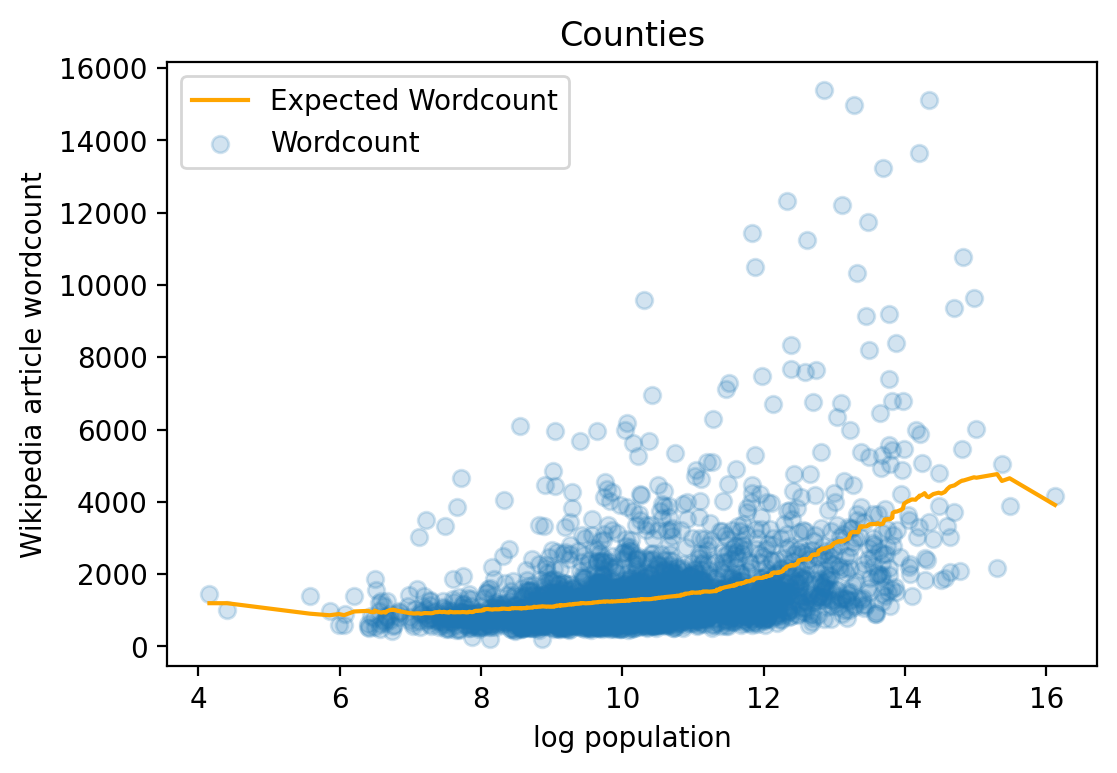

In [22]:
plt.figure(dpi=200)
plt.scatter(log_pop, wordcount, alpha=0.2, label="Wordcount")
plt.plot(log_pop[np.argsort(log_pop)], prediction[np.argsort(log_pop)], color="orange", label="Expected Wordcount")
plt.xlabel("log population")
plt.ylabel("Wikipedia article wordcount")
plt.title("Counties")
plt.legend()

In [23]:
overall["expected"] = prediction
overall["overperformance"] = (wordcount - prediction) / prediction * 100

In [24]:
mapping = dict(zip(overall.fips, overall.overperformance))

In [25]:
import plotly.graph_objects as go

BACKGROUND = "#222"

def trim(out_path):
    subprocess.check_call(
        [
            "inkscape",
            "--batch-process",
            "--verb",
            "EditSelectAll;FitCanvasToSelection;FileSave;FileQuit",
            out_path,
        ]
    )

def process(in_path, out_path):
    with open(in_path) as f:
        result = et.fromstring(f.read())

    gs = [grab_group(result, s) for s in ("choroplethlayer",)]
    result.clear()
    for g in gs:
        result.append(g)
    with open(out_path, "wb") as f:
        f.write(et.tostring(result))

    trim(out_path)

def produce_image(fips, z, zmin, zmax, output, **kwargs):
    fig = go.Figure(
        go.Choropleth(
            locations=fips,
            z=z,
            colorscale="Viridis",
            zmin=zmin,
            zmax=zmax,
            marker_line_width=0,
            **kwargs,
        )
    )
    fig.update(layout_showlegend=False)
    fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(geo=dict(bgcolor=BACKGROUND, lakecolor=BACKGROUND))
    fig.update_geos(scope="usa")
    fig.write_image(output)

In [26]:
import tempfile
import os
import requests
import geopandas

In [27]:
@permacache("county_importance_wikipedia/load_county_geojson_2")
def load_county_geojson():
    tempdir = tempfile.TemporaryDirectory()
    rootpath = tempdir.name
    os.system(f"mkdir -p {rootpath}")
    zip = requests.get(
        "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip"
    ).content
    with open(f"{rootpath}/hi.zip", "wb") as f:
        f.write(zip)
    os.system(f"cd {rootpath}; unzip hi.zip")

    return geopandas.read_file(f"{rootpath}/cb_2020_us_county_500k.shp")

In [28]:
geojson = load_county_geojson()
geojson["fips"] = geojson.STATEFP + geojson.COUNTYFP
geojson = geojson[geojson.STATEFP.apply(lambda x: x not in {"78", "60", "69", "66"})]
geojson = geojson.copy()
# geojson = geojson[geojson.fips != "02261"]

In [29]:
geojson["overperformance"] = geojson.apply(lambda row: mapping[row.fips], axis=1)

In [30]:
geojson.to_file("temp/out.shp")

/home/kavi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [31]:
csv = overall[
    ["state", "county", "POP100", "wordcount", "expected", "overperformance"]
].rename(
    columns={
        "POP100": "population",
        "expected": "expected wordcount",
        "overperformance": "relative wordcount",
    }
)
csv["relative wordcount"] /= 100
csv.to_csv("out.csv", index=False)